## Libraries

In [1]:
import math
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Engineering Weekly Data

Reading data from the checkpoints from before

Instead of aggregating the data on a daily level, we aggregrate the same on a weekly basis

In [2]:
df_weather = pd.read_csv('weather_data_cleaned.csv')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['YearWeek'] = df_weather['Date'].apply(lambda x: x.strftime('%Y%U'))

In [3]:
df_calls_daily = pd.read_csv('daily_calls_with_weather.csv')
del df_calls_daily['Date']
del df_calls_daily['MeanTemp']

df_calls_daily['Y-M-d'] = pd.to_datetime(df_calls_daily['Y-M-d'])
df_calls_daily['YearWeek'] = df_calls_daily['Y-M-d'].apply(lambda x: x.strftime('%Y%U'))

In [4]:
df_calls_daily = df_calls_daily.groupby('Y-M-d').agg({'Count': 'sum', 'YearWeek': 'unique'}) 

In [5]:
df_calls_daily = df_calls_daily.reset_index()
df_calls_daily['YearWeek'] = df_calls_daily['YearWeek'].apply(lambda x: x[0])

We now plot the distribution of the weather features on a weekly aggregated format

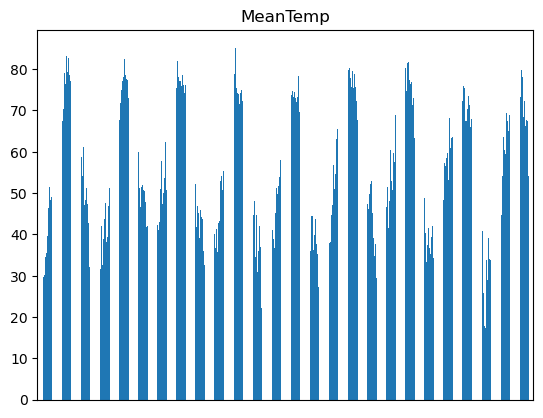

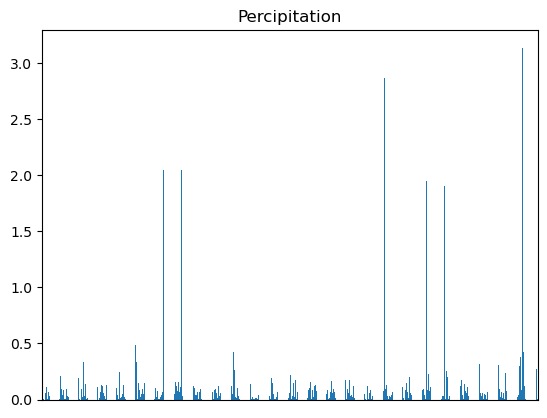

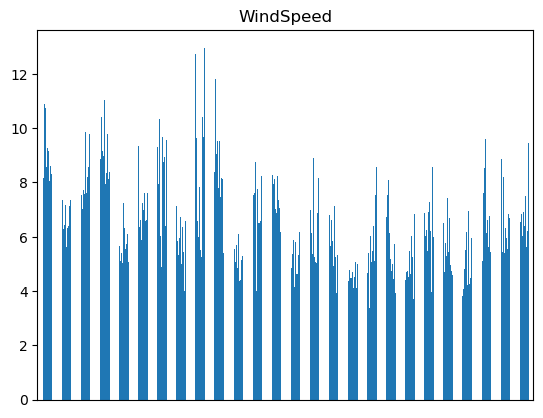

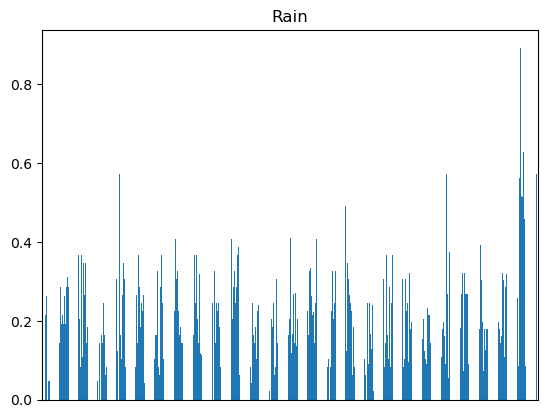

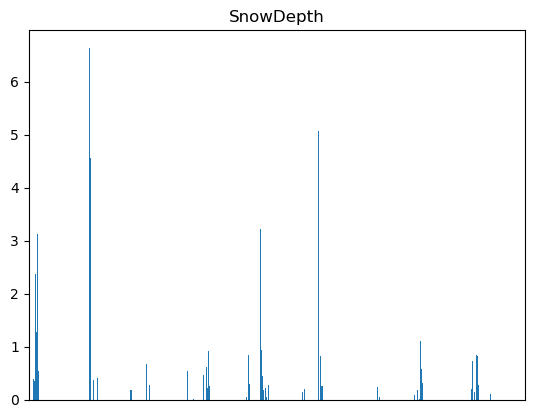

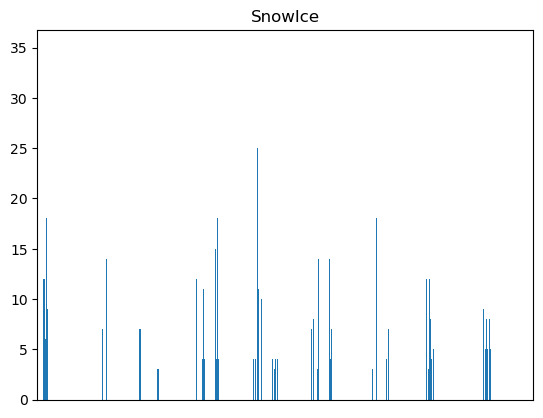

In [6]:
weather_cols = ['MeanTemp', 'Percipitation', 'WindSpeed', 'Rain', 'SnowDepth', 'SnowIce']
for i in weather_cols:
    if i == 'SnowIce':
        df_weather_temp = df_weather.groupby(['YearWeek']).agg({i: 'sum'}).reset_index()
    else:
        df_weather_temp = df_weather.groupby(['YearWeek']).agg({i: 'mean'}).reset_index()

    df_weather_temp.sort_values(['YearWeek'], inplace = True)
    df_weather_temp[i].plot(kind = 'bar')
    plt.xticks(np.arange(len(df_weather_temp), 12.0))
    plt.title(i)
    plt.show()

In [7]:
agg_cols = {
    'MeanTemp' : ['median', 'std'],
    'Percipitation' : ['median', 'std'],
    'WindSpeed' : ['median', 'std'],
    'Rain' : ['median', 'std'],
    'SnowDepth' : ['median', 'std'],
    'SnowIce' : ['sum']
}

df_weather = df_weather.groupby(['YearWeek']).agg(agg_cols)
df_weather.columns = ["_".join(i) for i in df_weather.columns]
df_weather = df_weather.reset_index()

In [8]:
final = pd.merge(df_calls_daily, df_weather, on = 'YearWeek', how = 'left')
final

,Y-M-d,Count,YearWeek,MeanTemp_median,MeanTemp_std,Percipitation_median,Percipitation_std,WindSpeed_median,WindSpeed_std,Rain_median,Rain_std,SnowDepth_median,SnowDepth_std,SnowIce_sum
0,2016-01-01,16680,201600,39.0,2.501030,0.0,0.025746,6.95,5.211526,0.0,0.000000,0.0,0.0,0.0
1,2016-01-02,18360,201600,39.0,2.501030,0.0,0.025746,6.95,5.211526,0.0,0.000000,0.0,0.0,0.0
2,2016-01-03,18570,201601,36.8,7.771757,0.0,0.000000,4.75,4.719816,0.0,0.210707,0.0,0.0,0.0
3,2016-01-04,35778,201601,36.8,7.771757,0.0,0.000000,4.75,4.719816,0.0,0.210707,0.0,0.0,0.0
4,2016-01-05,48666,201601,36.8,7.771757,0.0,0.000000,4.75,4.719816,0.0,0.210707,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2018-12-27,4733,201851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,2018-12-28,4294,201851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,2018-12-29,3492,201851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,2018-12-30,3500,201852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding weeks for which we do not have the weather information

In [9]:
null_dates = final[final['MeanTemp_median'].isnull()]['YearWeek'].unique()
print(null_dates)

['201846' '201847' '201848' '201849' '201850' '201851' '201852']


Perform the same ADF test again and decide whether or not to perform first differencing based on the p-values

ADF Statistic on the entire dataset: -10.690607781872012
p-value: 3.7344615296954506e-19
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276
ADF Statistic on the entire dataset: -6.319203697510393
p-value: 3.096004850261277e-08
Critical Values:
	1%: -3.444965543297668
	5%: -2.8679842369272976
	10%: -2.5702025382716047


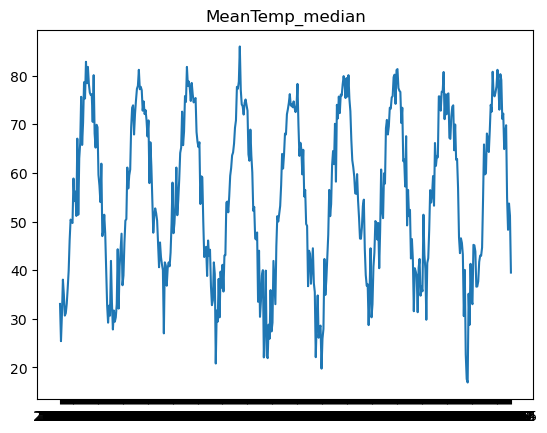

ADF Statistic on the entire dataset: 0.5926244490012599
p-value: 0.9874324166085993
Critical Values:
	1%: -3.444900499925237
	5%: -2.8679556266351653
	10%: -2.570187288941969
ADF Statistic on the entire dataset: -3.404298553625563
p-value: 0.01081320414208431
Critical Values:
	1%: -3.444965543297668
	5%: -2.8679842369272976
	10%: -2.5702025382716047


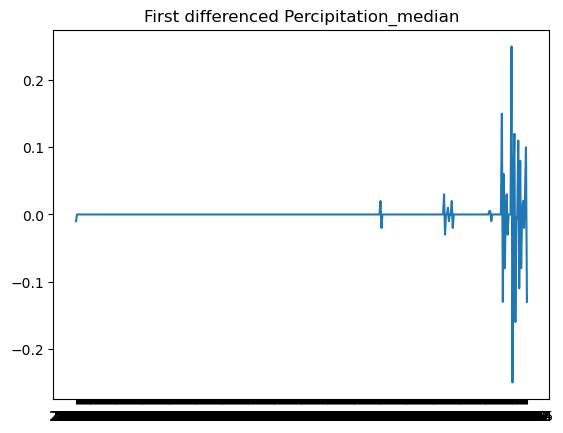

ADF Statistic on the entire dataset: -3.897811016491682
p-value: 0.0020510160105628107
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157
ADF Statistic on the entire dataset: -11.94714609889746
p-value: 4.403054105887727e-22
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157


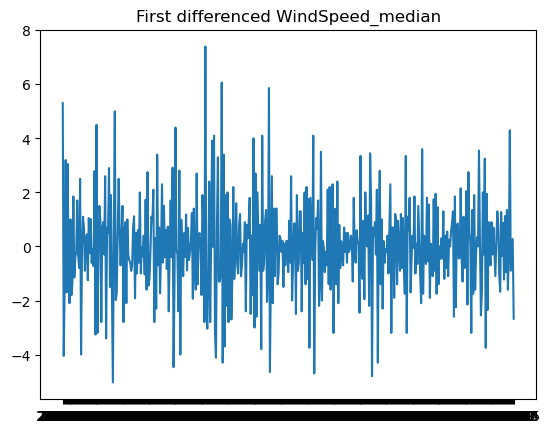

ADF Statistic on the entire dataset: -1.063155888360803
p-value: 0.7295391290675182
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276
ADF Statistic on the entire dataset: -5.831989162104051
p-value: 3.955428971354333e-07
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276


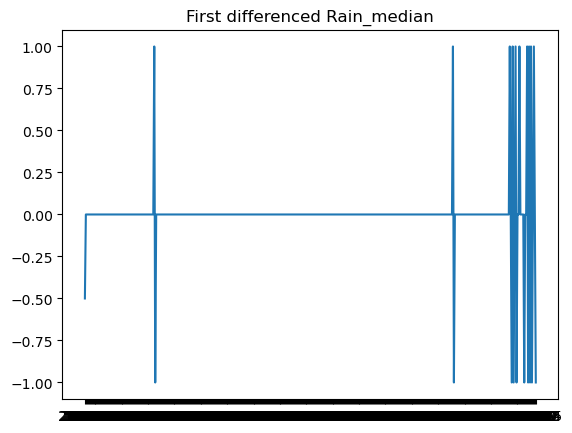

ADF Statistic on the entire dataset: -13.730640975534538
p-value: 1.1418867549239223e-25
Critical Values:
	1%: -3.4444002781824477
	5%: -2.867735576537528
	10%: -2.57007000456571
ADF Statistic on the entire dataset: -11.569868901065927
p-value: 3.1209847025294164e-21
Critical Values:
	1%: -3.4446773373329576
	5%: -2.8678574606780654
	10%: -2.5701349669405404


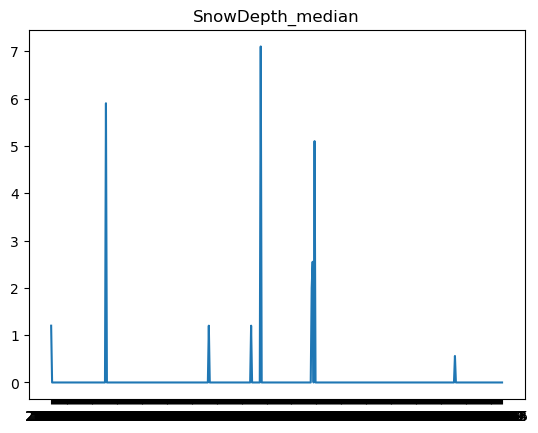

ADF Statistic on the entire dataset: -7.017701362016268
p-value: 6.666401608271999e-10
Critical Values:
	1%: -3.4444305322234365
	5%: -2.8677488864580885
	10%: -2.5700770984781443
ADF Statistic on the entire dataset: -13.25587167518684
p-value: 8.590398733783163e-25
Critical Values:
	1%: -3.4445220811896657
	5%: -2.8677891615873192
	10%: -2.5700985643950656


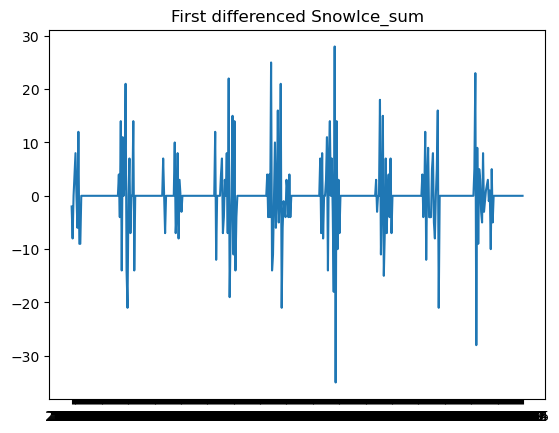

In [10]:
cols = ['MeanTemp_median', 'Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowDepth_median', 'SnowIce_sum']

train_portion = df_weather[~df_weather['YearWeek'].isin(null_dates)]
train_portion.set_index('YearWeek', inplace = True)

for i in cols:
    
    first_diff = train_portion[i].diff()[1:]


    result = adfuller(train_portion[i])
    print('ADF Statistic on the entire dataset: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


    result_diff = adfuller(first_diff)
    print('ADF Statistic on the entire dataset: {}'.format(result_diff[0]))
    print('p-value: {}'.format(result_diff[1]))
    print('Critical Values:')
    for key, value in result_diff[4].items():
        print('\t{}: {}'.format(key, value))


    if result_diff[1] > result[1]:
        plt.plot(train_portion[i])
        plt.title(i)
        plt.show()
    else:
        plt.plot(first_diff)
        plt.title(f'First differenced {i}')
        plt.show()

After having a good understanding of the features to do perform a first level differencing on, we plot the ACF and PACF plots for each 

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


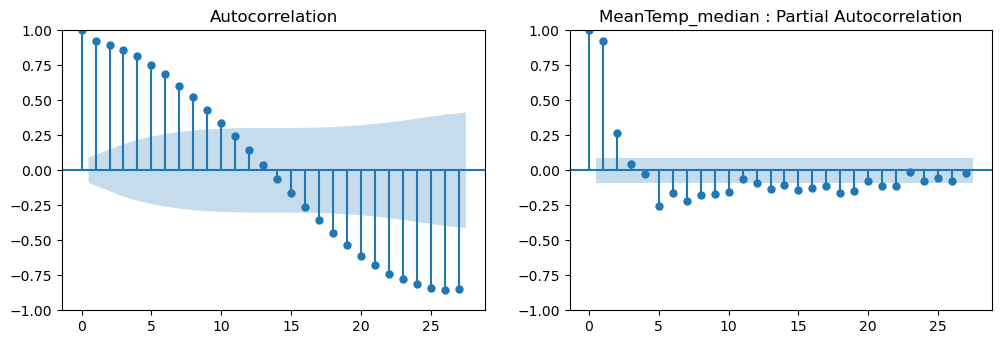

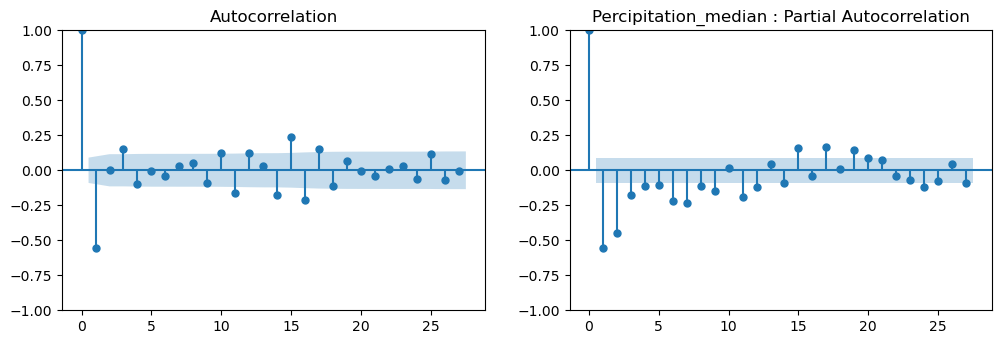

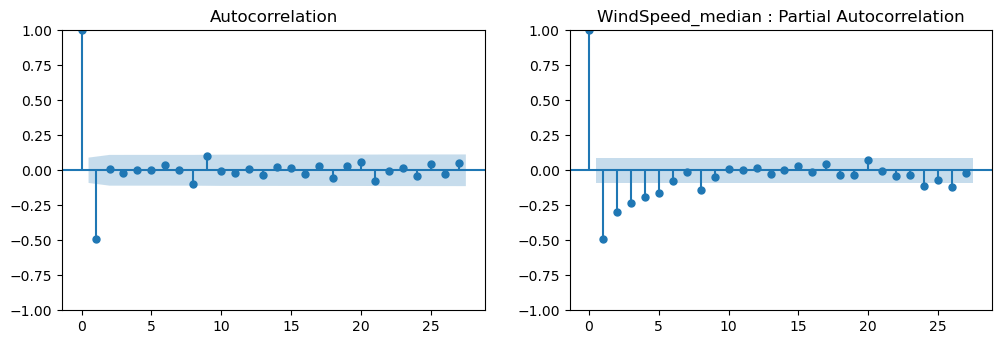

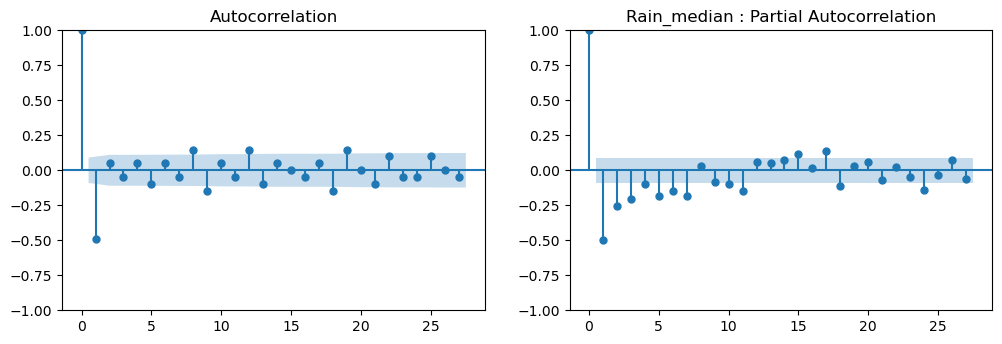

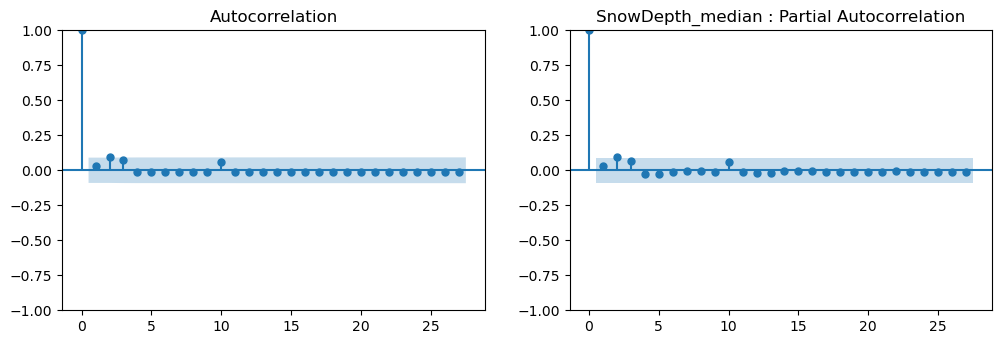

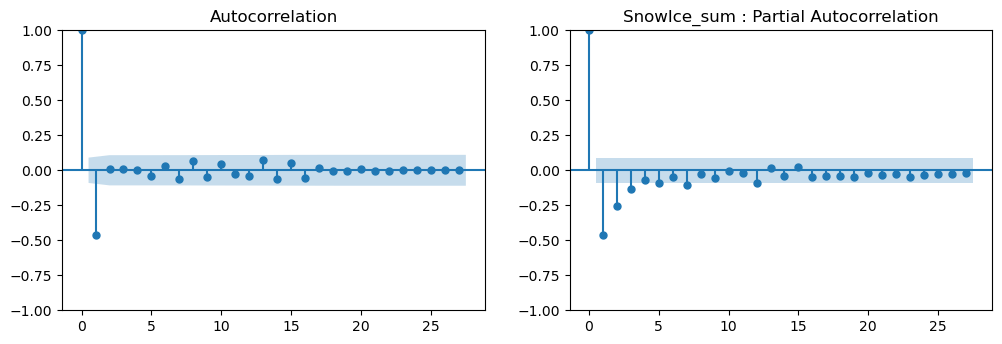

In [11]:
differencing = ['Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowIce_sum']

for i in cols:

    if i in differencing:
        first_diff = train_portion[i].diff()[1:]
    else:
        first_diff = train_portion[i]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(2,2,1)
    fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
    ax2 = fig.add_subplot(2,2,2)
    fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)
    ax2.set_title(f'{i} : Partial Autocorrelation')

In [12]:
order = {
    'MeanTemp_median': (2,0,10),
    'Percipitation_median': (4,1,1),
    'WindSpeed_median': (5,1,1),
    'Rain_median': (7,1,1),
    'SnowDepth_median': (2,0,4),
    'SnowIce_sum': (3,1,1)
}

In [13]:
train_portion

,MeanTemp_median,MeanTemp_std,Percipitation_median,Percipitation_std,WindSpeed_median,WindSpeed_std,Rain_median,Rain_std,SnowDepth_median,SnowDepth_std,SnowIce_sum
YearWeek,,,,,,,,,,,
201000,33.05,2.702524,0.01,0.117808,6.150,6.073358,0.5,0.522233,1.2,3.139448,10.0
201001,25.40,4.269384,0.00,0.011033,11.450,4.158050,0.0,0.000000,0.0,1.719932,8.0
201002,30.90,6.786858,0.00,0.000000,7.400,2.790138,0.0,0.000000,0.0,0.000000,0.0
201003,38.05,2.953456,0.00,0.162331,6.050,3.391351,0.0,0.415300,0.0,0.000000,0.0
201004,34.95,10.988860,0.00,0.306543,9.250,4.899607,0.0,0.445001,0.0,1.279440,4.0
...,...,...,...,...,...,...,...,...,...,...,...
201841,54.90,4.153251,0.02,0.031294,10.000,3.255460,0.0,0.502096,0.0,0.000000,0.0
201842,48.30,3.650238,0.00,0.219009,9.100,4.554973,0.0,0.443440,0.0,0.000000,0.0
201843,53.70,5.937607,0.03,0.171984,8.800,3.346631,1.0,0.502096,0.0,0.000000,0.0


Calculate multicollinearity using VIF

In [14]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = cols
  
vif_train_portion = train_portion.loc[:, cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(cols))]
  
print(vif_data)

                feature       VIF
0       MeanTemp_median  6.514540
1  Percipitation_median  1.887852
2      WindSpeed_median  7.847371
3           Rain_median  1.926902
4      SnowDepth_median  1.633242
5           SnowIce_sum  2.408795


In [15]:
vif_data = pd.DataFrame()
subset_cols = ['MeanTemp_median', 'Percipitation_median', 'Rain_median', 'SnowDepth_median', 'SnowIce_sum']
vif_data["feature"] = subset_cols
vif_train_portion = vif_train_portion.loc[:, subset_cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(subset_cols))]

print(vif_data)                          

                feature       VIF
0       MeanTemp_median  1.109764
1  Percipitation_median  1.886503
2           Rain_median  1.926514
3      SnowDepth_median  1.522580
4           SnowIce_sum  1.592920


Removing WindSpeed_median as it expresses high multicollinearity

In [16]:
import warnings
warnings.simplefilter("ignore")
cols.remove('WindSpeed_median')

Developed a cross-validated ARIMA model and used it to make future predictions


=======================================MeanTemp_median=======================================
Average RMSE: 31.307978625683045
Average MAPE: 0.07819760412536177

=======================================Percipitation_median=======================================
Average RMSE: 0.004500113182130228
Average MAPE: 140.9971352209496

=======================================Rain_median=======================================
Average RMSE: 0.2514731014163335
Average MAPE: 18.615099566970535

=======================================SnowDepth_median=======================================
Average RMSE: 0.0053401744318362495
Average MAPE: 1.0

=======================================SnowIce_sum=======================================
Average RMSE: 4.556602828179949
Average MAPE: 0.9439890702973626



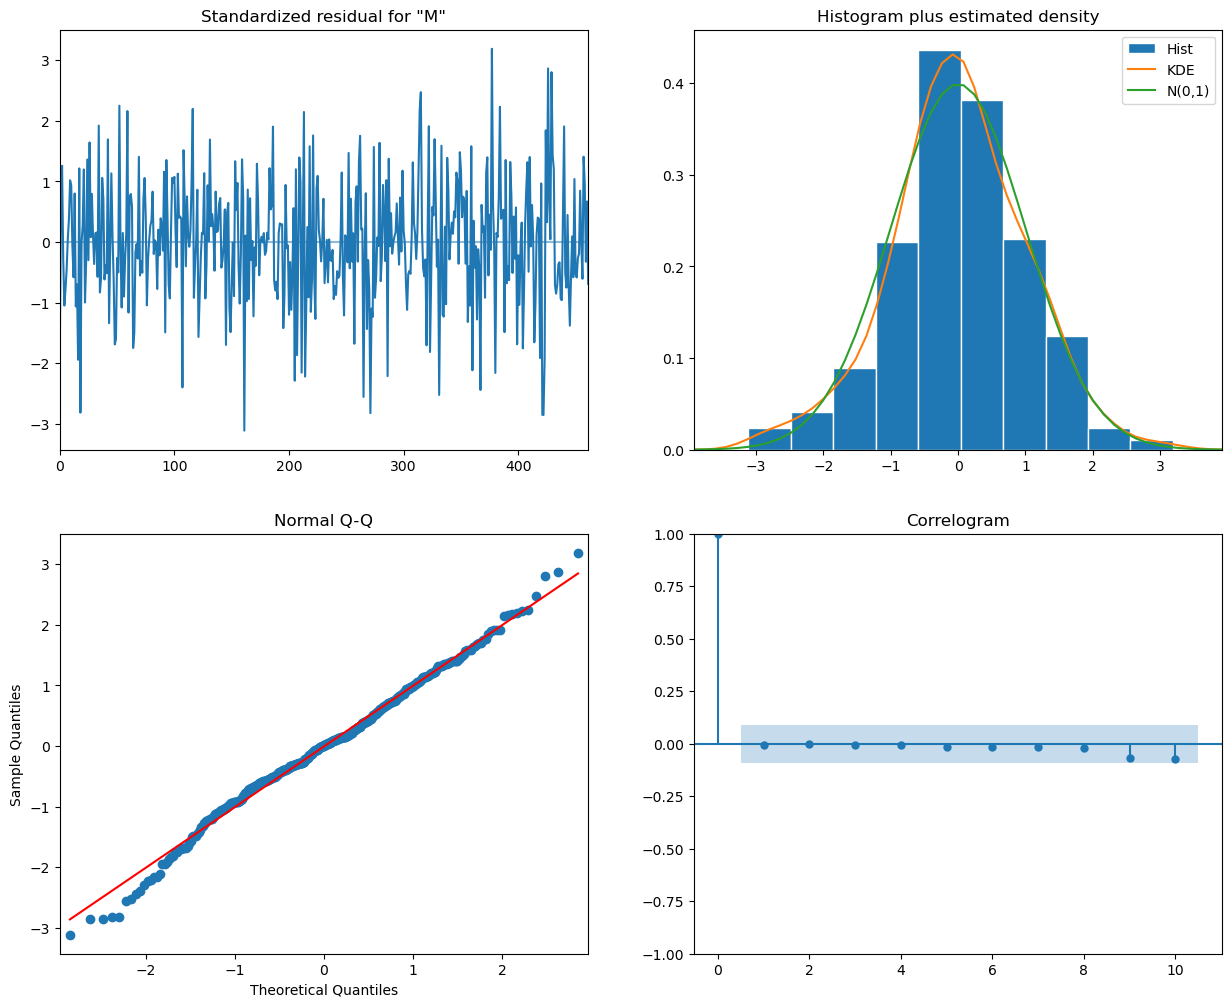

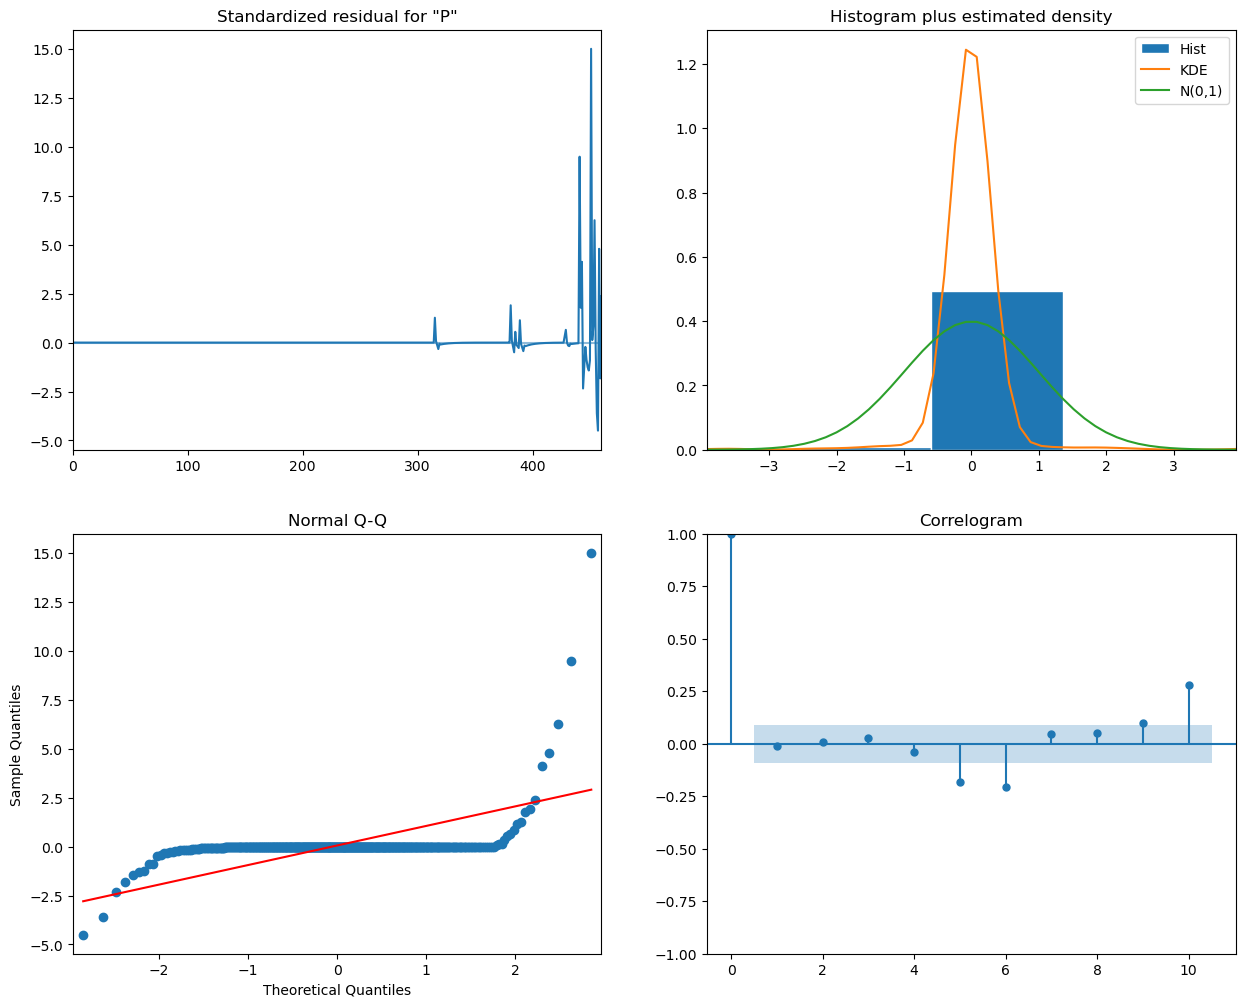

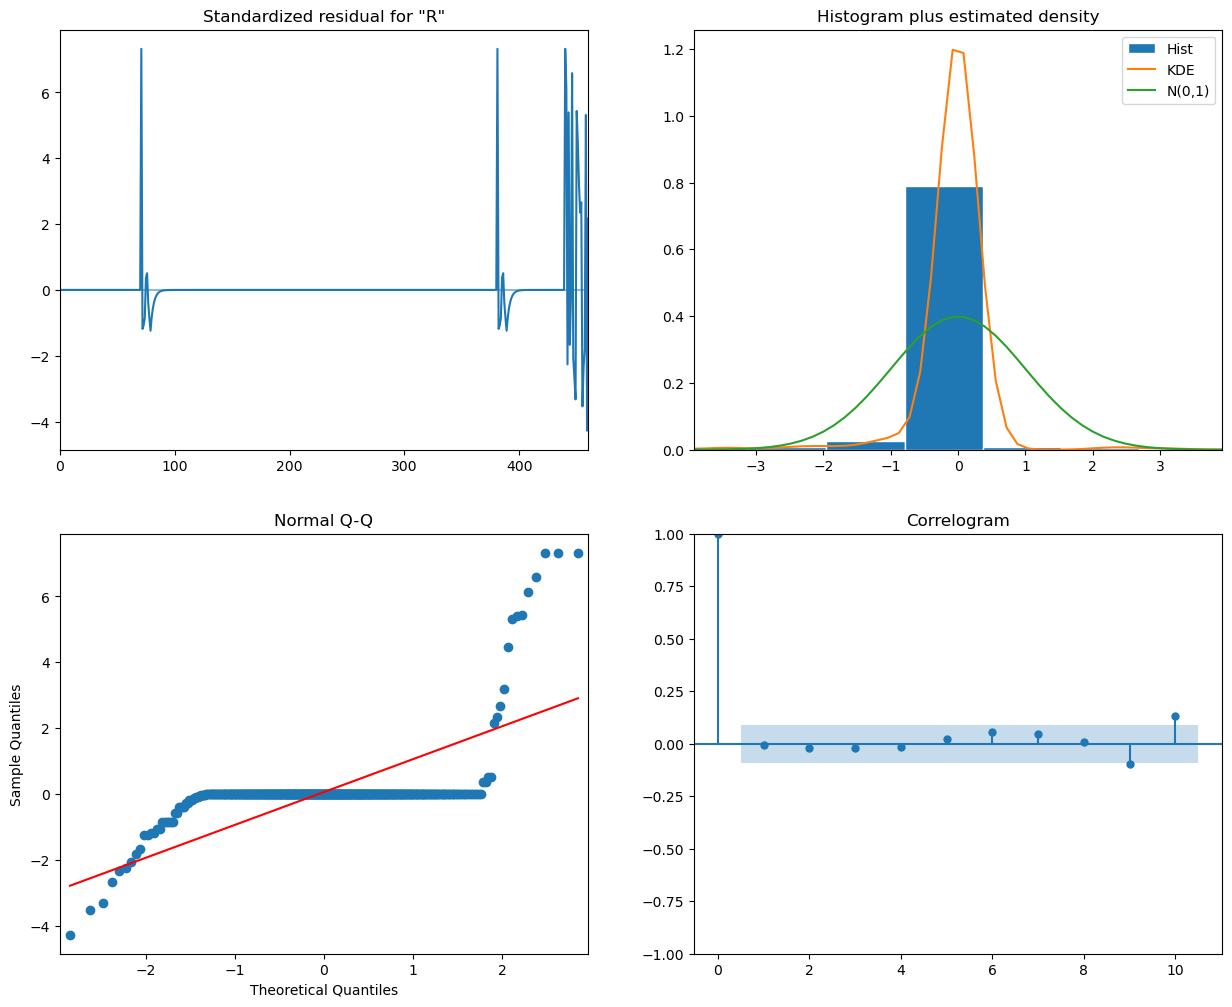

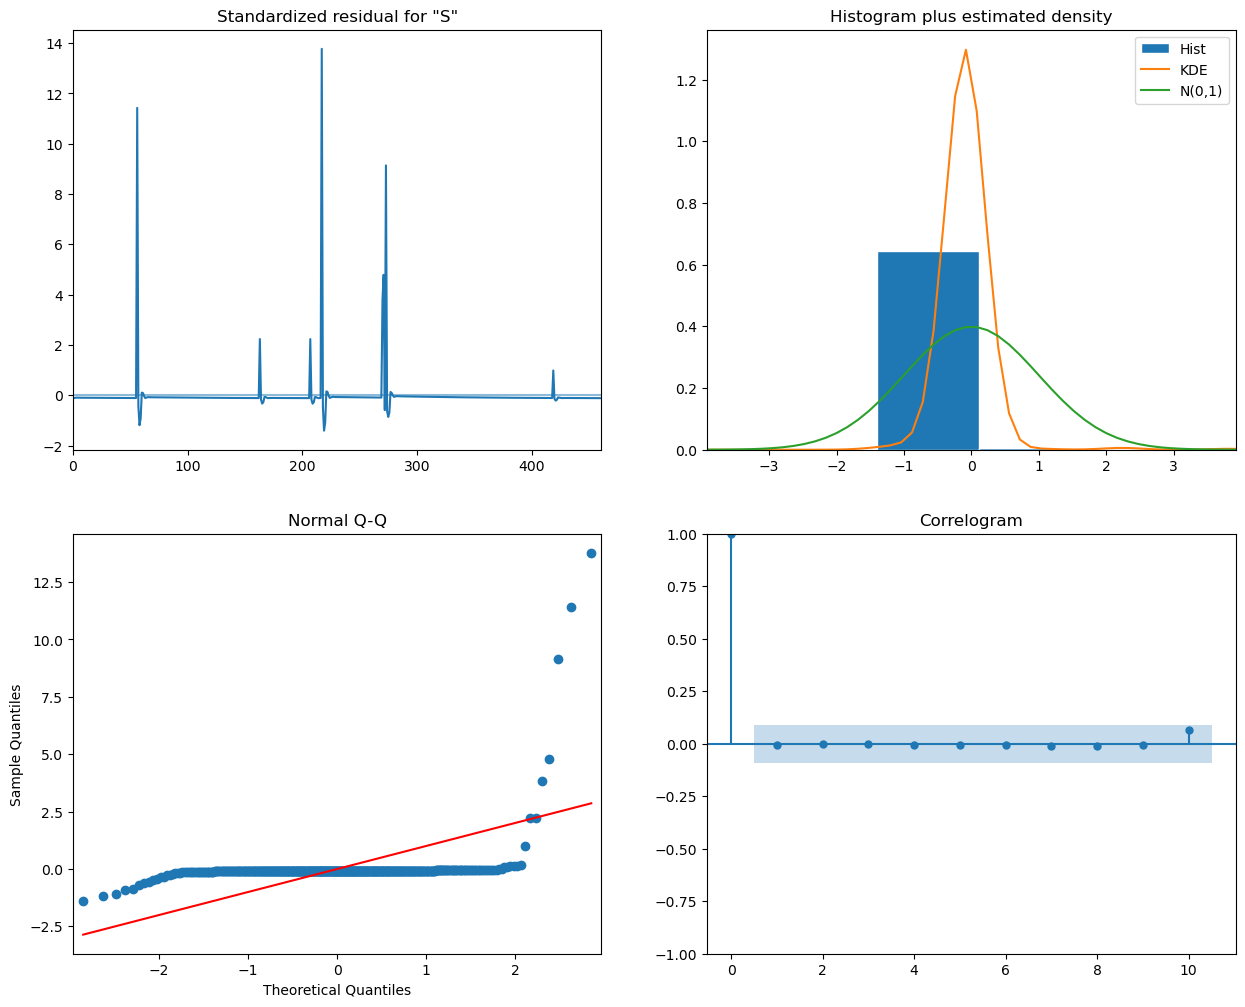

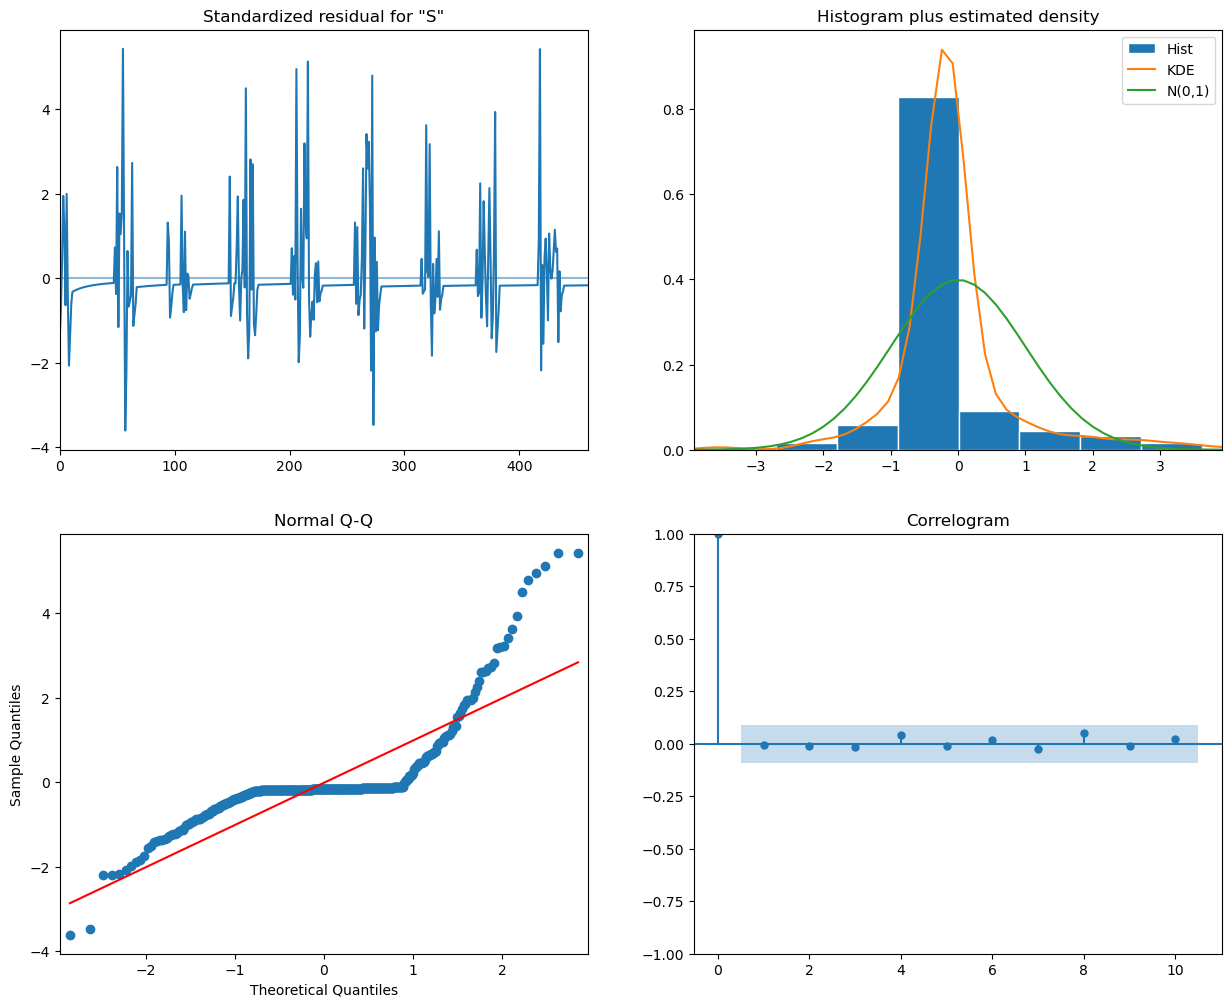

In [17]:
num_folds = 5

for i in cols:
    print(f"======================================={i}=======================================")
    rmse = []
    mape = []
    for j in range(num_folds):
        train_data = train_portion[i][1:-(7 * (num_folds-j))]
        val_data = train_portion[i][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

        model = ARIMA(train_data, order = order[i])
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        
        predictions = model_fit.get_forecast(7)

        prediction = predictions.predicted_mean
        prediction_range = predictions.conf_int(alpha=0.05)
        deviation = (prediction - prediction_range.iloc[:,-1])/2

        rmse.append(mean_squared_error(prediction, list(val_data)))
        mape.append(mean_absolute_percentage_error(prediction, list(val_data)))

    rmse = np.array(rmse)
    mape = np.array(mape)

    model_fit.plot_diagnostics(figsize=(15, 12))

    print(f'Average RMSE: {np.mean(rmse)}')
    print(f'Average MAPE: {np.mean(mape)}')

    print()


We make predictions for 7 weeks by predicting the average temperature for each week

In [18]:
temperature_column = cols[0]

train_data = train_portion[temperature_column]

model = ARIMA(train_data, order = order[temperature_column])
model_fit = model.fit(method_kwargs={"warn_convergence": False})

predictions = model_fit.get_forecast(7)

prediction = predictions.predicted_mean
prediction_range = predictions.conf_int(alpha=0.05)
deviation = (prediction - prediction_range.iloc[:,-1])/2
deviation = abs(deviation)

In [19]:
temperature_predictions = list(train_portion[temperature_column].values[list(train_portion.index).index('201600'):]) + list(prediction)
temperature_deviation = list(train_portion['MeanTemp_std'].values[list(train_portion.index).index('201600'):]) + list(deviation)

In [20]:
engineered_dataset = pd.DataFrame()
engineered_dataset['YearWeek'] = final['YearWeek']
engineered_dataset['Count'] = final['Count']
engineered_dataset['Date'] = final['Y-M-d']
engineered_dataset

,YearWeek,Count,Date
0,201600,16680,2016-01-01
1,201600,18360,2016-01-02
2,201601,18570,2016-01-03
3,201601,35778,2016-01-04
4,201601,48666,2016-01-05
...,...,...,...
1091,201851,4733,2018-12-27
1092,201851,4294,2018-12-28
1093,201851,3492,2018-12-29
1094,201852,3500,2018-12-30


In [21]:
temperature = pd.DataFrame()
temperature['YearWeek'] = engineered_dataset['YearWeek'].unique()
temperature['WeekMeanTemp'] = temperature_predictions
temperature['WeekTempStd'] = temperature_deviation

In [22]:
engineered_dataset = pd.merge(engineered_dataset, temperature, on = 'YearWeek', how = 'left')
engineered_dataset

,YearWeek,Count,Date,WeekMeanTemp,WeekTempStd
0,201600,16680,2016-01-01,39.000000,2.501030
1,201600,18360,2016-01-02,39.000000,2.501030
2,201601,18570,2016-01-03,36.800000,7.771757
3,201601,35778,2016-01-04,36.800000,7.771757
4,201601,48666,2016-01-05,36.800000,7.771757
...,...,...,...,...,...
1091,201851,4733,2018-12-27,33.853557,5.144074
1092,201851,4294,2018-12-28,33.853557,5.144074
1093,201851,3492,2018-12-29,33.853557,5.144074
1094,201852,3500,2018-12-30,33.068500,5.202969


In [23]:
engineered_dataset.to_csv('engineered_dataset_weekly.csv', index = False)

We also make predictions for the 8th week, to account for the exogenous variable used for predicting the future

In [24]:
future_predictions = model_fit.get_forecast(8)

In [25]:
future_prediction_values = future_predictions.predicted_mean
future_prediction_range = future_predictions.conf_int(alpha=0.05)
future_prediction_deviation = (future_prediction_values - future_prediction_range.iloc[:,-1])/2
future_prediction_deviation = abs(future_prediction_deviation)

In [26]:
future_prediction_data = pd.DataFrame()
future_prediction_data['WeekMeanTemp'] = future_prediction_values
future_prediction_data['WeekTempStd'] = future_prediction_deviation

Saving another checkpoint

In [27]:
future_prediction_data.to_csv('future_prediction_weekly_data.csv', index = False)